# Results 

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf 
import numpy as np
import pickle
import data
import sys
import os

from sklearn.metrics import precision_recall_fscore_support
from models.plstm import PhasedClassifier
from models.lstm import LSTMClassifier


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

%load_ext autoreload
%autoreload 2

### Testing data

In [3]:
test_batches = data.load_record(source='./data/records/macho/test', batch_size=32, take=-1)
n_classes = [len(b[1][0]) for b in test_batches.take(1)][0]
n_classes

[INFO] No shuffle No Oversampling


7

### Model instantiation

In [4]:
lstm_model = LSTMClassifier(256, 
                       n_classes, 
                       dropout=0.5, 
                       lr=1e-3,
                       name='lstm')

plstm_model = PhasedClassifier(256, 
                         n_classes, 
                         dropout=0.5, 
                         lr=1e-3,
                         name='phased')

loading weights

In [5]:
lstm_model.load_ckpt('./experiments/macho_lstm/ckpts/')
plstm_model.load_ckpt('./experiments/macho_phased/ckpts/')

RNN Restored!
RNN Restored!


### Prediction 

In [6]:
y_pred_lstm, y_true_lstm     = lstm_model.predict_proba(test_batches, concat_batches=True)
y_pred_phased, y_true_phased = plstm_model.predict_proba(test_batches, concat_batches=True)

runtime 15.42
runtime 42.02


from one-hot encoding to label enconding

In [7]:
true_lstm = tf.argmax(y_true_lstm, 1)
true_phased = tf.argmax(y_true_phased, 1)

changing to time first

In [8]:
pred_lstm_time   = tf.transpose(y_pred_lstm, [1,0,2])
pred_phased_time = tf.transpose(y_pred_phased, [1,0,2])
pred_phased_time.shape

TensorShape([1807, 529, 7])

getting last state prediction

In [9]:
y_last_lstm = tf.argmax(pred_lstm_time[-1, :, :], 1)
y_last_phased = tf.argmax(pred_phased_time[-1, :, :], 1)
y_last_lp = tf.argmax((pred_lstm_time[-1, :, :] + pred_phased_time[-1, :, :])/2, 1)

In [20]:
prec_lstm, rec_lstm, f1_lstm, _ = precision_recall_fscore_support(true_lstm, y_last_lstm, 
                                                                  average='macro')
prec_phased, rec_phased, f1_phased, _ = precision_recall_fscore_support(true_phased, y_last_phased, 
                                                                       average='macro')
prec_lp, rec_lp, f1_lp, _ = precision_recall_fscore_support(true_phased, y_last_lp, 
                                                                       average='macro')

In [21]:
print('Macro F1 LSTM: {:.2f}'.format(f1_lstm))
print('Macro F1 Phased: {:.2f}'.format(f1_phased))
print('Macro F1 L+P: {:.2f}'.format(f1_lp))

Macro F1 LSTM: 0.81
Macro F1 Phased: 0.70
Macro F1 L+P: 0.79


### Online metrics

In [14]:
f1_online_lstm   = []
f1_online_phased = []
f1_online_lp     = []
for step_lstm, step_phased in zip(pred_lstm_time, pred_phased_time):
    
    # L+P PROBABILITIES
    step_lp = (step_lstm + step_phased)/2

    # Predicted Labels
    pred_a = tf.argmax(step_phased, 1) # PHASED
    pred_b = tf.argmax(step_lstm, 1) # LSTM
    pred_c = tf.argmax(step_lp, 1) # L+P
    
    # Metrics 
    
    prec, rec, f1, _ = precision_recall_fscore_support(true_lstm, pred_b, average='macro')
    f1_online_lstm.append(f1)
    
    prec, rec, f1, _ = precision_recall_fscore_support(true_lstm, pred_a, average='macro')
    f1_online_phased.append(f1)
    
    prec, rec, f1, _ = precision_recall_fscore_support(true_lstm, pred_c, average='macro')
    f1_online_lp.append(f1)

/home/ubuntu/miniconda3/envs/tf2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/miniconda3/envs/tf2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/miniconda3/envs/tf2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

/home/ubuntu/miniconda3/envs/tf2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/miniconda3/envs/tf2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/miniconda3/envs/tf2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

/home/ubuntu/miniconda3/envs/tf2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/miniconda3/envs/tf2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


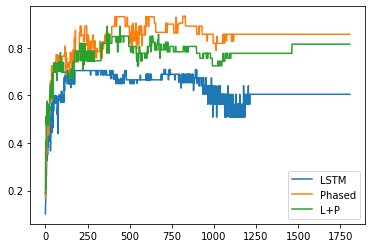

In [17]:
plt.plot(f1_online_lstm, label='LSTM')
plt.plot(f1_online_phased, label='Phased')
plt.plot(f1_online_lp, label='L+P')
plt.legend()
